<div class="alert alert-warning">
    
<b>Disclaimer:</b> 
    
The main objective of the <i>Jupyter</i> notebooks in this folder is to show how to use the models of the <i>QENS library</i> by


- building a fitting model: composition of models, convolution with a resolution function  
- setting and running the fit  
- extracting and displaying information about the results  

These steps have a minimizer-dependent syntax. That's one of the reasons why different minimizers have been used in the notebooks provided as examples.  
But, note that the initial guessed parameters might not be optimal, resulting in a poor fit of the reference data.
    
</div>

# Brownian Translational diffusion &lowast; Resolution with bumps

## Introduction

<div class="alert alert-info">
    
The objective of this notebook is to show how to use the <b>Brownian Translational diffusion</b> model to perform some 
fits using <a href="https://github.com/bumps/bumps">bumps</a> .
</div>

The **reference data** were generated data corresponding to a Brownian Translational diffusion model with self-diffusion coefficient = 0.145 &#x212B;$^2\times$meV.

The model was convoluted with a Gaussian resolution function 
of FWHM = 0.1 meV, centered randomly in the range \[-0.01, +0.01\] meV.

Finally the data are sampled randomly from a Poisson distribution.

The data do not have a background.

### Physical units

For information about unit conversion, please refer to the jupyter notebook called `Convert_units.ipynb` in the `tools` folder.

The dictionary of units defined in the cell below specify the units of the refined parameters adapted to the convention used in the experimental datafile.

In [1]:
# Units of parameters for selected QENS model and experimental data
dict_physical_units = {'D': "meV.Angstrom^2", 
                       'scale': "unit_of_signal.meV", 
                       'center': "meV"}

## Import the required libraries

In [2]:
import ipywidgets
import numpy as np
import h5py
import QENSmodels
from scipy.integrate import simps
import bumps.names as bmp
from bumps import fitters
from bumps.formatnum import format_uncertainty_pm
import matplotlib.pyplot as plt

%matplotlib widget

## Setting of fitting

### Load reference data

In [3]:
path_to_data = './data/'

# Read the sample
with h5py.File(path_to_data + 'BrownianDiff_Sample.hdf', 'r') as f:
    hw = f['entry1']['data1']['X'][:]
    q = f['entry1']['data1']['Y'][:]
    unit_w=f['entry1']['data1']['X'].attrs['long_name']
    unit_q=f['entry1']['data1']['Y'].attrs['long_name']
    sqw = np.transpose(f['entry1']['data1']['DATA'][:])
    err = np.transpose(f['entry1']['data1']['errors'][:])

# Read resolution
with h5py.File(path_to_data + 'BrownianDiff_Resol.hdf', 'r') as f:
    res = np.transpose(f['entry1']['data1']['DATA'][:])

# Force resolution function to have unit area
for i in range(len(q)):
    area = simps(res[:,i], hw)
    res[:,i] /= area   

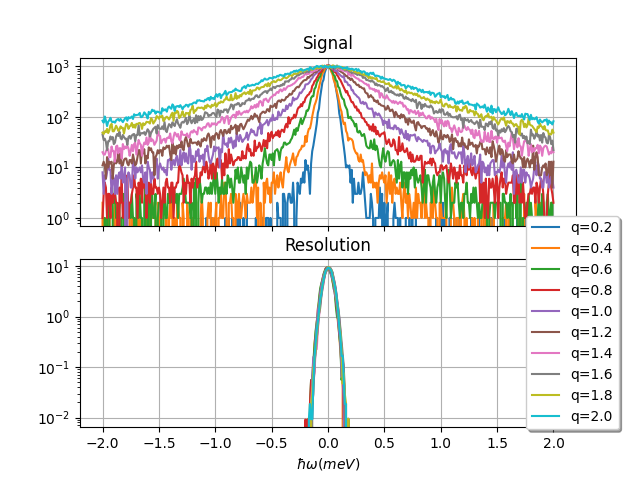

In [4]:
fig, ax = plt.subplots(nrows=2, sharex=True)

for i in range(len(q)):
    ax[0].semilogy(hw, sqw[:,i], label=f"q={q[i]:.1f}")
    ax[1].semilogy(hw, res[:,i], label=f"q={q[i]:.1f}")

ax[1].legend(bbox_to_anchor=(1.1,1.3), loc='upper right', shadow=True)
ax[0].set_title('Signal')
ax[0].grid()
ax[1].set_title('Resolution')
ax[1].set_xlabel(f"$\hbar \omega ({dict_physical_units['center']})$")

ax[1].grid()

### Display units of input data
Just for information in order to determine if a conversion of units is required before using the QENSmodels

In [5]:
print(f"The names and units of `w` (`x`axis) and `q` are: {unit_w[0].decode()} and {unit_q[0].decode()}, respectively.")

The names and units of `w` (`x`axis) and `q` are: X and Y, respectively.


### Create fitting model

In [12]:
# Fitting model 
def model_convol(x, q, scale=1, center=0, D=1, resolution=None):
    """ """
    model = QENSmodels.sqwBrownianTranslationalDiffusion(x, q, scale, center, D)
    return np.convolve(model, resolution/resolution.sum(), mode='same')

# Fit
Model = []

for i in range(len(q)):
    # Bumps fitting model
    Modelq = bmp.Curve(
        model_convol, 
        hw, 
        sqw[:,i], 
        err[:,i], 
        q=q[i],
        scale=1000, 
        center=0.0, 
        D=0.1, 
        resolution=res[:, i])
    
    Modelq.scale.range(0, 1e5)
    Modelq.center.range(-0.1, 0.1)
    Modelq.D.range(0, 1)
    
    # Q-independent parameters
    if i == 0:
        QD = Modelq.D  
    else:
        Modelq.D = QD
    Model.append(Modelq)
        
problem = bmp.FitProblem(Model)

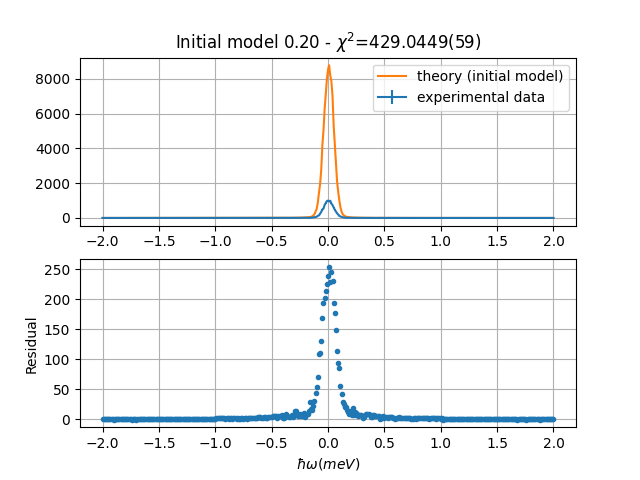

In [13]:
slider = ipywidgets.IntSlider(value=0, min=0, max=len(q)-1, continuous_update=False)
output = ipywidgets.Output()

with output:
    model = Model[0]
    fig = plt.figure()
    plt.subplot(211)
    ini_plot0 = plt.errorbar(model.x,
                       model.y, 
                       yerr=model.dy,
                       label='experimental data')
    ini_plot1 = plt.plot(model.x,
                   model.theory(), 
                   label='theory (initial model)')
    plt.title(f'Initial model {q[0]:.2f} - $\chi^2$={problem.chisq_str()}')
    plt.legend()
    plt.grid()
    plt.subplot(212)
    plt.ylabel('Residual')
    plt.xlabel(f"$\hbar \omega ({dict_physical_units['center']})$")
    res_plot = plt.plot(model.x, 
                            model.residuals(), 
                            marker='o', linewidth=0, markersize=3)
    plt.grid()
        
def update_profile(change):
    with output:
        fig.clear()
        model = Model[change['new']]
        
        plt.subplot(211)
        plt.errorbar(model.x,
                       model.y, 
                       yerr=model.dy,
                       label='experimental data')
        plt.plot(model.x,
                   model.theory(), 
                   label='theory (initial model)')
        plt.title(f"Model {q[change['new']]:.2f} - $\chi^2$={problem.chisq_str()}")
        plt.legend()
        plt.grid()
        
        plt.subplot(212)
        plt.ylabel('Residual')
        plt.xlabel(f"$\hbar \omega ({dict_physical_units['center']})$")
        plt.plot(model.x, 
                 model.residuals(), 
               marker='o', linewidth=0, markersize=3)
        plt.grid()
        fig.canvas.draw()
            
slider.observe(update_profile, names="value")

slider_label = ipywidgets.Label("q value to display")
slider_comp = ipywidgets.HBox([slider_label, slider])
ipywidgets.VBox([slider_comp, output])

In [14]:
problem.summarize().splitlines()

['                                       D |.........        0.1 in (0,1)',
 '                                  center ....|.....          0 in (-0.1,0.1)',
 '                                   scale |.........       1000 in (0,100000)',
 '                                  center ....|.....          0 in (-0.1,0.1)',
 '                                   scale |.........       1000 in (0,100000)',
 '                                  center ....|.....          0 in (-0.1,0.1)',
 '                                   scale |.........       1000 in (0,100000)',
 '                                  center ....|.....          0 in (-0.1,0.1)',
 '                                   scale |.........       1000 in (0,100000)',
 '                                  center ....|.....          0 in (-0.1,0.1)',
 '                                   scale |.........       1000 in (0,100000)',
 '                                  center ....|.....          0 in (-0.1,0.1)',
 '                               

###  Choice of minimizer for bumps

In [15]:
options_dict = {} 

for item in fitters.__dict__.keys():
    if item.endswith('Fit') and fitters.__dict__[item].id in fitters.FIT_AVAILABLE_IDS:
        options_dict[fitters.__dict__[item].name] = fitters.__dict__[item].id

w_choice_minimizer = ipywidgets.Dropdown(
    options=list(options_dict.keys()),
    value='Levenberg-Marquardt',
    description='Minimizer:',
    layout=ipywidgets.Layout(height='40px'))

w_choice_minimizer

Dropdown(description='Minimizer:', index=4, layout=Layout(height='40px'), options=('Differential Evolution', '…

### Setting for running bumps

In [16]:
steps_fitting = ipywidgets.IntText(
    value=100,
    step=100,
    description='Number of steps when fitting',
    style={'description_width': 'initial'})

steps_fitting

IntText(value=100, description='Number of steps when fitting', step=100, style=DescriptionStyle(description_wi…

In [17]:
# Preview of the settings
print('Initial chisq', problem.chisq_str())

# problem.plot()

Initial chisq 429.0449(59)


## Running the fit

Run the fit using the *minimizer* defined above with a number of *steps* also specified above

In [18]:
def settings_selected_optimizer(chosen_minimizer):
    """ 
    List the settings available for the selected optimizer
    
    This list can be used as arguments for the `fit` function
    """
    
    assert type(chosen_minimizer) == ipywidgets.widgets.widget_selection.Dropdown
    
    for item in fitters.__dict__.keys():
        if item.endswith('Fit') and \
        fitters.__dict__[item].id == options_dict[chosen_minimizer.value]:
            return [elt[0] for elt in fitters.__dict__[item].settings]

In [19]:
print((f"With {w_choice_minimizer.value} optimizer, "
      f"you can use {settings_selected_optimizer(w_choice_minimizer)} as arguments of `fit`"))

With Levenberg-Marquardt optimizer, you can use ['steps', 'ftol', 'xtol'] as arguments of `fit`


In [20]:
result = fitters.fit(
    problem,
    starts=10,
    keep_best=True,
    method=options_dict[w_choice_minimizer.value], 
    steps=int(steps_fitting.value))

In [21]:
print('Initial chisq', problem.chisq_str())

Initial chisq 204.7840(59)


In [22]:
problem.summarize().splitlines()

['                                       D .|........   0.135867 in (0,1)',
 '                                  center .....|.... 0.00170004 in (-0.1,0.1)',
 '                                   scale |.........    747.479 in (0,100000)',
 '                                  center ....|..... -0.000398478 in (-0.1,0.1)',
 '                                   scale |.........    811.731 in (0,100000)',
 '                                  center ....|..... -0.00157941 in (-0.1,0.1)',
 '                                   scale |.........    583.401 in (0,100000)',
 '                                  center .....|.... 0.00087767 in (-0.1,0.1)',
 '                                   scale |.........     768.34 in (0,100000)',
 '                                  center ....|..... -0.00202517 in (-0.1,0.1)',
 '                                   scale |.........    841.509 in (0,100000)',
 '                                  center ....|..... -0.00148103 in (-0.1,0.1)',
 '                          

## Showing the results

In [23]:
# problem.plot()

In [24]:
# Print chi**2 and parameters' values after fit
print("final chisq", problem.chisq_str())
for k, v, dv in zip(problem.labels(), result.x, result.dx):
    if k in dict_physical_units.keys():
        print(k, ":", format_uncertainty_pm(v, dv), dict_physical_units[k])
    else:
        print(k, ":", format_uncertainty_pm(v, dv))

final chisq 204.7840(59)
D : 0.13587 +/- 0.00020 meV.Angstrom^2
center : 0.001700 +/- 0.000073 meV
scale : 747.5 +/- 1.1 unit_of_signal.meV
center : -0.40e-3 +/- 0.10e-3 meV
scale : 811.7 +/- 1.3 unit_of_signal.meV
center : -0.00158 +/- 0.00025 meV
scale : 583.4 +/- 1.5 unit_of_signal.meV
center : 0.88e-3 +/- 0.33e-3 meV
scale : 768.3 +/- 1.8 unit_of_signal.meV
center : -0.00203 +/- 0.00054 meV
scale : 841.5 +/- 2.2 unit_of_signal.meV
center : -0.00148 +/- 0.00082 meV
scale : 899.2 +/- 2.7 unit_of_signal.meV
center : -0.38e-3 +/- 0.83e-3 meV
scale : 1087.7 +/- 3.2 unit_of_signal.meV
center : -1.3e-3 +/- 1.3e-3 meV
scale : 1220.6 +/- 3.6 unit_of_signal.meV
center : 1.0e-3 +/- 1.8e-3 meV
scale : 1177.3 +/- 4.1 unit_of_signal.meV
center : 3.5e-3 +/- 4.2e-3 meV
scale : 817.2 +/- 4.7 unit_of_signal.meV


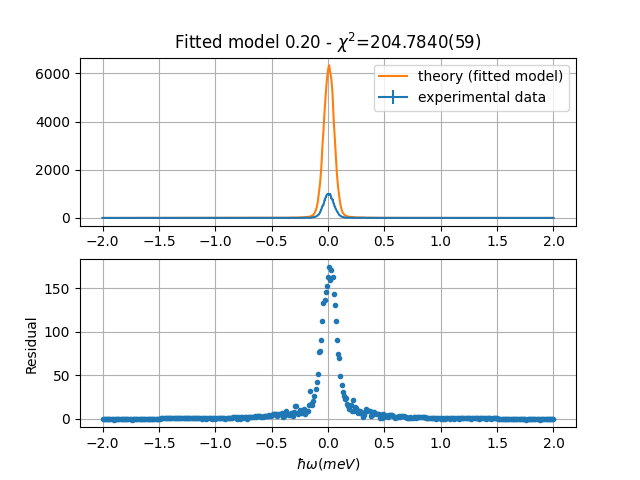

In [25]:
slider = ipywidgets.IntSlider(value=0, min=0, max=len(q)-1, continuous_update=False)
output = ipywidgets.Output()

with output:
    model = Model[0]
    fig = plt.figure()
    plt.subplot(211)
    plt.errorbar(model.x,
                       model.y, 
                       yerr=model.dy,
                       label='experimental data')
    plt.plot(model.x,
                   model.theory(), 
                   label='theory (fitted model)')
    plt.title(f'Fitted model {q[0]:.2f} - $\chi^2$={problem.chisq_str()}')
    plt.legend()
    plt.grid()
    plt.subplot(212)
    plt.ylabel('Residual')
    plt.xlabel(f"$\hbar \omega ({dict_physical_units['center']})$")
    res_plot = plt.plot(model.x,
                        model.residuals(),
                        marker='o', linewidth=0, markersize=3)
    plt.grid()
        
def update_profile(change):
    with output:
        fig.clear()
        model = Model[change['new']]
        
        plt.subplot(211)
        plt.errorbar(model.x,
                     model.y, 
                     yerr=model.dy,
                     label='experimental data')
        plt.plot(model.x,
                   model.theory(), 
                   label='theory (fitted model)')
        plt.title(f"Model {q[change['new']]:.2f} - $\chi^2$={problem.chisq_str()}")
        plt.legend()
        plt.grid()
        
        plt.subplot(212)
        plt.ylabel('Residual')
        plt.xlabel(f"$\hbar \omega ({dict_physical_units['center']})$")
        plt.plot(model.x, 
                 model.residuals(), 
               marker='o', linewidth=0, markersize=3)
        plt.grid()
        fig.canvas.draw()
            
slider.observe(update_profile, names="value")

slider_label = ipywidgets.Label("q value to display")
slider_comp = ipywidgets.HBox([slider_label, slider])
ipywidgets.VBox([slider_comp, output])